# Learned Reconstruction

In inverse problems, we want to recover some signal $x$ from noisy measurements $y$ where we know the forward model $\mathcal{T} : \mathcal{X} \to \mathcal{Y}$
$$
    y = \mathcal{T}(x) + e
$$
In machine learning for inverse problems we aim to find some operator $\mathcal{T}_\theta^\dagger : \mathcal{Y} \to \mathcal{X}$ that inverts this process
$$
    \mathcal{T}_\theta^\dagger(y) \approx x
$$

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset. We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to FBP-based reconstruction.

The results should be approximately

| Method                 |  Mean Error  |
|------------------------|----------|
| FBP                    | 0.01694  |
| Fully learned          | 0.00226  |
| FBP + learned denoiser | 0.00260  |
| Learned Iterative      | 0.005150 |

Note that the examples in this notebook may take some time to run, approximately 10-15 minutes each can be expected on a reasonable laptop.

**Note:** This is a pytorch port of [the notebook using tensorflow](part3_learned_reconstruction.ipynb) with reduced text, see the other notebook for more details.

In [1]:
!pip install https://github.com/odlgroup/odl/archive/master.zip

     | 1.7 MB 10.4 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odl: filename=odl-1.0.0.dev0-py2.py3-none-any.whl size=764689 sha256=79f47154693bfee0de74f344b1c725c15e417e3a92e91cc3bdae6a5b17c9f616
  Stored in directory: /tmp/pip-ephem-wheel-cache-ud1_uvtc/wheels/15/cb/19/a2170a930202b3b653e4855edeaf5a23a6e6bee81ae82d1f0f
Successfully built odl


In [2]:
!pip install torchmetrics
import optimizers as op
import regularizers as reg
import aux_funs as maf
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 17.4 MB/s eta 0:00:00


In [3]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import odl
from odl.contrib.torch import OperatorModule
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
torch.manual_seed(123);  # reproducibility

## Get training and test data

We create loaders for the MNIST data:

In [25]:
from torch.utils.data import random_split
from torchvision import datasets, transforms

# Define the desired total subset size (e.g., 6000 samples)
total_subset_size = 600  # 6000 samples for the whole subset
train_val_split = [500, 100]  # Split the 6000 subset into 5000 for training, 1000 for validation

# Define transformations: convert to Tensor and normalize
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalization based on MNIST mean and std dev
])

# Load the MNIST dataset
dset_train_val = datasets.MNIST('./data', train=True, download=True, transform=trafo)

# Step 1: Subset the original dataset to a smaller size (6000 samples in total)
subset_train_val, _ = random_split(dset_train_val, [total_subset_size, len(dset_train_val) - total_subset_size])

# Step 2: Further split the smaller subset into training and validation sets
train_dataset, val_dataset = random_split(subset_train_val, train_val_split)

# Loaders for training and validation using the smaller dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True)

# Test Dataset (remains the full test set)
dset_test = datasets.MNIST('./data', train=False, transform=trafo)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(dset_test)}')

Train dataset size: 500
Validation dataset size: 100
Test dataset size: 10000


## Create ODL objects

We initialize the ray transform on a space suitable for the MNIST images. We also create a filtered backprojection (FBP) operator for comparison, and for the FBP denoising net later on:

In [26]:
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
fwd_op = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(fwd_op)

## Make pytorch `Module`s from ODL operators

For use in our neural networks, we create pytorch modules from the above operators. For this we use the `OperatorAsModule` class from `odl.contrib.torch`. It implements automatic differentiation as required for backpropagation in pytorch, and it supports extra batch and channel axes.

In [27]:
fwd_op_mod = OperatorModule(fwd_op)
fwd_op_adj_mod = OperatorModule(fwd_op.adjoint)
fbp_op_mod = OperatorModule(fbp_op)

## Some helper functions

For the generation of noisy projection data and for visualization of the results we use the following helpers:

In [28]:
def generate_data(images):
    """Create noisy projection data from images.

    The data is generated according to ::

        data = fwd_op(images) + noise

    where ``noise`` is standard white noise.

    Parameters
    ----------
    images : `Variable`, shape ``(B, C, 28, 28)``
        Input images for the data generation.

    Returns
    -------
    data : `Variable`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = fwd_op_mod(images)
    data += Variable(torch.randn(data.shape)).type_as(data)
    return data


def show_image_matrix(image_batches, titles=None, indices=None, **kwargs):
    """Visualize a 2D set of images arranged in a grid.

    This function shows a 2D grid of images, where the i-th column
    shows images from the i-th batch. The typical use case is to compare
    results of different approaches with the same data, or to compare
    against a ground truth.

    Parameters
    ----------
    image_batches : sequence of `Tensor` or `Variable`
        List containing batches of images that should be displayed.
        Each tensor should have the same shape after squeezing, except
        for the batch axis.
    titles : sequence of str, optional
        Titles for the colums in the plot. By default, titles are empty.
    indices : sequence of int, optional
        Object to select the subset of the images that should be shown.
        The subsets are determined by slicing along the batch axis, i.e.,
        as ``displayed = image_batch[indices]``. The default is to show
        everything.
    kwargs :
        Further keyword arguments that are passed on to the Matplotlib
        ``imshow`` function.
    """
    import matplotlib.pyplot as plt

    if indices is None:
        displayed_batches = image_batches
    else:
        displayed_batches = [batch[indices] for batch in image_batches]

    displayed_batches = [batch.data if isinstance(batch, Variable) else batch
                         for batch in displayed_batches]

    nrows = len(displayed_batches[0])
    ncols = len(displayed_batches)

    if titles is None:
        titles = [''] * ncols

    figsize = 2
    fig, rows = plt.subplots(
        nrows, ncols, sharex=True, sharey=True,
        figsize=(ncols * figsize, figsize * nrows))

    if nrows == 1:
        rows = [rows]

    for i, row in enumerate(rows):
        if ncols == 1:
            row = [row]
        for name, batch, ax in zip(titles, displayed_batches, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(batch[i].squeeze(), **kwargs)
            ax.set_axis_off()
    plt.show()

## Generate test data

We take one batch from the test dataset and generate the corresponding test projection data for validation:

In [29]:
# Get a batch of test images and generate test projection data
for i, (images, _) in enumerate(test_loader):
    if i == 1:
        break

test_images = Variable(images)
test_data = generate_data(test_images)

## FBP reconstruction

First we make a simple FBP reconstruction and compare it to the ground truth.

Average error: tensor(0.0113)


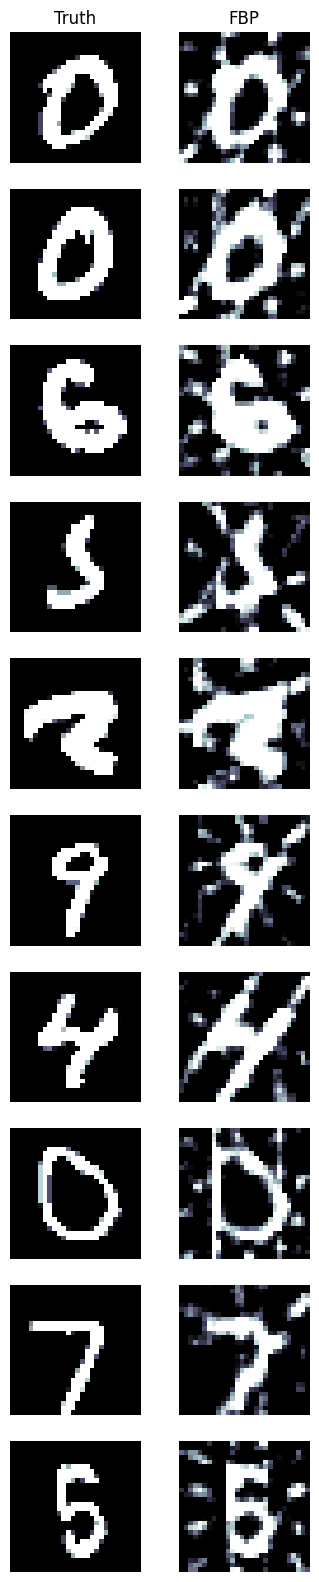

In [30]:
fbp_recos = fbp_op_mod(test_data)
print('Average error:', F.mse_loss(fbp_recos, test_images).data / len(test_images))

# Display examples
results = [test_images, fbp_recos]
titles = ['Truth', 'FBP']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

## Fully learned reconstruction

Now for the first neural network that learns how to reconstruct. We use a rather simple approach of fully connected layers at each level, gradually proceeding from size `5 * 41` to size `28 * 28`:

In [102]:
class FullRecoNet(nn.Module):
    def __init__(self):
        super(FullRecoNet, self).__init__()
        self.lin1 = nn.Linear(5 * 41, 1024)
        self.lin2 = nn.Linear(1024, 1024)
        self.lin3 = nn.Linear(1024, 28 ** 2)

    def forward(self, x):
        x = F.relu(self.lin1(x.view(-1, 5 * 41)))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x.view(-1, 1, 28, 28)

In [114]:

def init_weights(model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0.1, 0.1, ltype=torch.nn.Linear)
    maf.sparse_weight_normal_(model, 0.1, ltype=torch.nn.Linear)
    maf.sparsify_(model, 0.4, ltype=nn.Linear, conv_group=False)
    return model


# Initialize the weights
model = init_weights(FullRecoNet())

print('net_sparse', maf.net_sparsity(model))

net_sparse 0.40014903129657226


Let's train the network and see how well it does. We run 1 epoch for each model to have a somewhat fair comparison.

In [115]:
# Use these parameters to steer the training
use_cuda = False
learning_rate = 0.001
log_interval = 20
loss_train = nn.MSELoss()
loss_test = nn.MSELoss()
weights_linear = maf.get_weights_linear(model)
biases = maf.get_bias(model)
lamda_1=0.005
beta=0.5
delta=1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = op.LinBreg([{'params': weights_linear, 'lr' : learning_rate, 'reg' : reg.reg_l1(lamda=lamda_1), 'momentum': beta,'delta': delta},
#                           {'params': biases, 'lr': learning_rate, 'reg' : reg.reg_l1(lamda=lamda_1),'momentum':beta}])


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=10,threshold=0.0001)


In [116]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd  # Import pandas for CSV saving

epochs = 300

# Lists to store epoch, validation loss, and sparsity
epoch_list = []
val_loss_list = []
sparsity_list = []

# Training function
def train(epoch):
    model.train()  # Set model to training mode
    train_loss = 0
    total_mse = 0
    num_batches = len(train_loader)

    for batch_idx, (images, _) in enumerate(train_loader):
        if use_cuda:
            images = images.cuda()
        images = Variable(images)

        # Generate projections and reconstructions
        projs = generate_data(images)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through the denoising network
        output = model(projs)

        # Compute training loss (MSE in this case)
        loss = loss_train(output, images)
        train_loss += loss.item()  # Accumulate loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average training loss and MSE after the epoch
    avg_train_loss = train_loss / num_batches
    avg_train_mse = total_mse / num_batches
    print(f'\nTrain Epoch: {epoch} Average Loss: {avg_train_loss:.6f}', 'net_sparse', maf.net_sparsity(model))

# Validation function
def validate(epoch):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    total_mse = 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for val_images, _ in val_loader:
            if use_cuda:
                val_images = val_images.cuda()
            val_images = Variable(val_images)

            val_projs = generate_data(val_images)
            output = model(val_projs)

            # Compute validation loss (MSE)
            loss = loss_train(output, val_images)
            val_loss += loss.item()  # Accumulate validation loss

    # Compute average validation loss after the epoch
    avg_val_loss = val_loss / num_batches
    avg_val_mse = total_mse / num_batches
    print(f'\nValidation Epoch: {epoch} learning rate: {learning_rate} Average Loss: {avg_val_loss:.6f}')

    return avg_val_loss  # Return average validation loss

# Training loop
for epoch in range(1, epochs + 1):
    train(epoch)  # Train the model for one epoch
    avg_val_loss = validate(epoch)  # Validate the model and get the avg validation loss

    # Store epoch, validation loss, and sparsity
    epoch_list.append(epoch)
    val_loss_list.append(avg_val_loss)
    sparsity_list.append(maf.net_sparsity(model))

    # Scheduler step based on validation loss
    if scheduler is not None:
        scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

# Save results to CSV
results_df = pd.DataFrame({
    'Epoch': epoch_list,
    'Validation Loss': val_loss_list,
    'Sparsity': sparsity_list
})

results_df.to_csv('Adam_training_results.csv', index=False)
print("Training results saved to 'Adam_training_results.csv'")




Train Epoch: 1 Average Loss: 0.962177 net_sparse 0.9797308704359166

Validation Epoch: 1 learning rate: 0.001 Average Loss: 0.867899

Train Epoch: 2 Average Loss: 0.756945 net_sparse 0.9804925212680079

Validation Epoch: 2 learning rate: 0.001 Average Loss: 0.689926

Train Epoch: 3 Average Loss: 0.663895 net_sparse 0.9817058261922503

Validation Epoch: 3 learning rate: 0.001 Average Loss: 0.639437

Train Epoch: 4 Average Loss: 0.623622 net_sparse 0.9820725828986587

Validation Epoch: 4 learning rate: 0.001 Average Loss: 0.616426

Train Epoch: 5 Average Loss: 0.597117 net_sparse 0.9821084823646299

Validation Epoch: 5 learning rate: 0.001 Average Loss: 0.585742

Train Epoch: 6 Average Loss: 0.556757 net_sparse 0.9821768854011426

Validation Epoch: 6 learning rate: 0.001 Average Loss: 0.533757

Train Epoch: 7 Average Loss: 0.503916 net_sparse 0.98219095411078

Validation Epoch: 7 learning rate: 0.001 Average Loss: 0.489955

Train Epoch: 8 Average Loss: 0.462354 net_sparse 0.982195805389

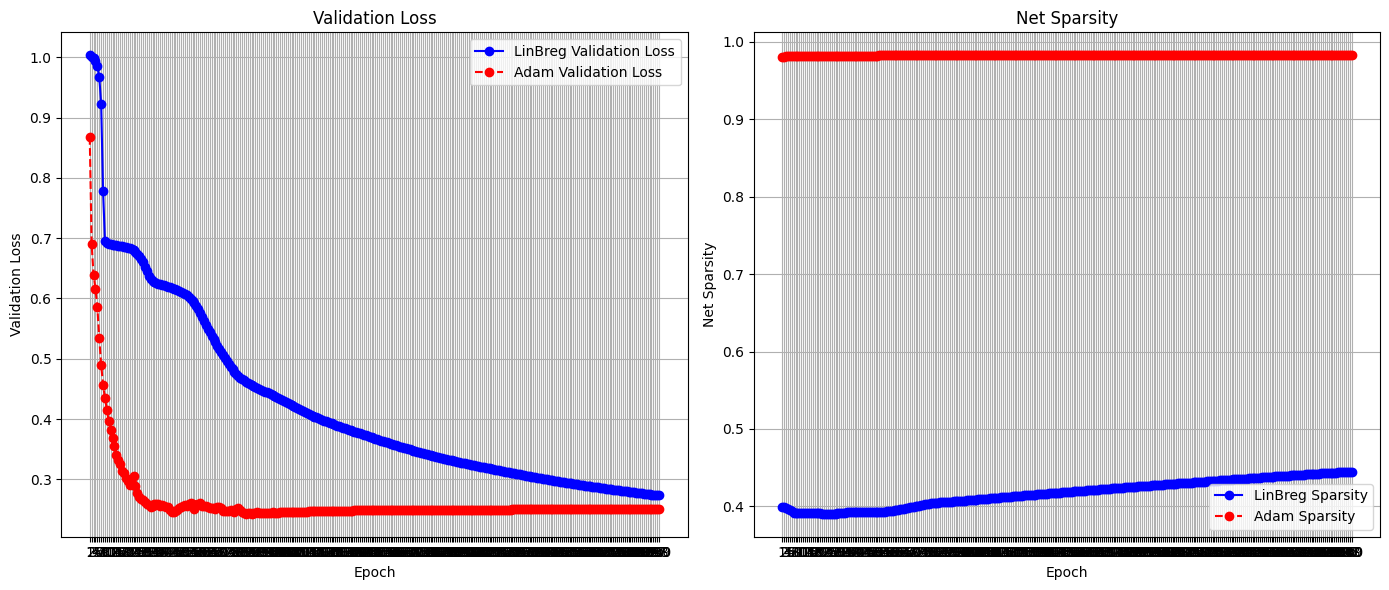

In [118]:
import pandas as pd  # For reading the CSV files
import matplotlib.pyplot as plt  # For plotting

# Load the training results from CSV files
linbreg_results = pd.read_csv('LinBreg_training_results.csv')
adam_results = pd.read_csv('Adam_training_results.csv')

# Extract columns for plotting
epochs_linbreg = linbreg_results['Epoch']
val_loss_linbreg = linbreg_results['Validation Loss']
sparsity_linbreg = linbreg_results['Sparsity']

epochs_adam = adam_results['Epoch']
val_loss_adam = adam_results['Validation Loss']
sparsity_adam = adam_results['Sparsity']

# Create a figure for the plots
plt.figure(figsize=(14, 6))

# Plot 1: Validation Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_linbreg, val_loss_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Validation Loss')
plt.plot(epochs_adam, val_loss_adam, marker='o', linestyle='--', color='r', label='Adam Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

# Plot 2: Sparsity vs Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_linbreg, sparsity_linbreg, marker='o', linestyle='-', color='b', label='LinBreg Sparsity')
plt.plot(epochs_adam, sparsity_adam, marker='o', linestyle='--', color='r', label='Adam Sparsity')
plt.title('Net Sparsity')
plt.xlabel('Epoch')
plt.ylabel('Net Sparsity')
plt.xticks(range(1, max(len(epochs_linbreg), len(epochs_adam)) + 1))  # Set x-ticks to be the epochs
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('training_plots_comparison.png')  # Save the figure as a PNG file
plt.show()  # Show the plots


Visualizing a sample from the results in comparison to FBP:

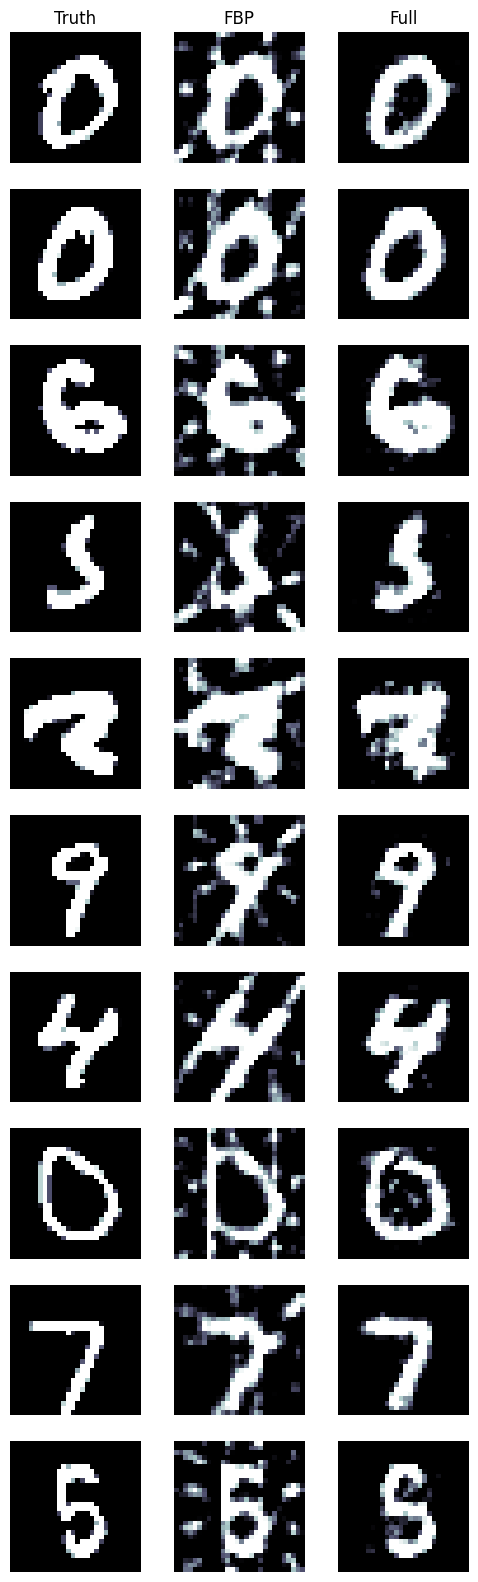

net_sparse 0.982536365188773


In [119]:
test_res_full = model(test_data)
results = [test_images.cpu(), fbp_recos.cpu(), test_res_full.cpu()]
titles = ['Truth', 'FBP', 'Full']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')
print('net_sparse', maf.net_sparsity(model))

These examples look much better than FBP (unsurprisingly), but there are still some issues with noise, deformations etc.

To also make an assessment about the number of trainable parameters and thus the scalability of the approach (the more parameters, the harder to train), the total number of parameters in the model can be checked like this:

In [84]:
print('Total number of parameters:',
      sum(param.numel() for param in model.parameters()))
print('Training data size:', 600 * 28 ** 2)

Total number of parameters: 2064144
Training data size: 470400


It turns out that for this tiny problem, the number of parameters is over 2 million. This is still a good deal away from the input data size (47 million), but overfitting is likely with this network. Therefore we explore sparser architectures.